<a href="https://colab.research.google.com/github/sowmyakovur20/ML-Projects/blob/main/ML_Universal_Sentence_Outlet_and_Bias_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install tensorflow_text>=2.0.0rc0

In [ ]:
!pip3 install tf_sentencepiece

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random


# Keras (2.2.4) and tensorflow (1.13).
import tensorflow as tf
import tensorflow_hub as hub
#import tf_sentencepiece

from keras.regularizers import l1, l2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import backend
from keras import optimizers

#sklearn and imblearn modules:
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE

#Import SVM
from sklearn.svm import SVC, LinearSVC
from sklearn import svm
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier


In [ ]:
dataset_df = pd.read_csv('/content/drive/MyDrive/archive1/articles1.csv')

In [ ]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   50000 non-null  int64  
 1   id           50000 non-null  int64  
 2   title        50000 non-null  object 
 3   publication  50000 non-null  object 
 4   author       43694 non-null  object 
 5   date         50000 non-null  object 
 6   year         50000 non-null  float64
 7   month        50000 non-null  float64
 8   url          0 non-null      float64
 9   content      50000 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 3.8+ MB


In [ ]:
dataset_df.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [ ]:
#taking 40% of the total dataset
p = 0.4
#import random
random_df = pd.read_csv('/content/drive/MyDrive/archive1/articles1.csv',header=None,skiprows=lambda i: 1>0 and random.random() > p)
news_atlantic = random_df[random_df[3] == 'Atlantic']
news_newyorkp = random_df[random_df[3] == 'Business Insider']
n_s_breit = random_df[random_df[3] == 'Breitbart']
n_s_newyorkt = random_df[random_df[3] == 'New York Times']

In [ ]:
print(news_atlantic)

           0      1  ...   8                                                  9
19907  53121  73207  ... NaN  George Michael Mattered Beyond the MusicWesley...
19908  53123  73209  ... NaN  As a writer, I generally favor words over numb...
19909  53125  73211  ... NaN  If recent measures of public opinion hold, Pre...
19910  53128  73214  ... NaN  The end of the year is a time for taking stock...
19911  53131  73217  ... NaN     Future nuclear missiles may be siloed but, ...
...      ...    ...  ...  ..                                                ...
19965  53283  73461  ... NaN          This article is part of a feature we a...
19966  53284  73462  ... NaN  President Obama’s farewell speech was an exerc...
19967  53286  73464  ... NaN  A large cohort of Americans have reservations ...
19968  53288  73466  ... NaN  I’ve spent nearly 20 years looking at intellig...
19969  53289  73467  ... NaN    Donald Trump will not be taking necessary st...

[63 rows x 10 columns]


In [ ]:
print(n_s_newyorkt)

         0      1  ...   8                                                  9
0        0  17283  ... NaN  WASHINGTON  —   Congressional Republicans have...
1        3  17286  ... NaN  Death may be the great equalizer, but it isn’t...
2        4  17287  ... NaN  SEOUL, South Korea  —   North Korea’s leader, ...
3        9  17292  ... NaN  Angels are everywhere in the Muñiz family’s ap...
4       10  17293  ... NaN  With Donald J. Trump about to take control of ...
...    ...    ...  ...  ..                                                ...
3093  7792  26523  ... NaN  “The cameras are over,” Garth Brooks said late...
3094  7797  26532  ... NaN  RIO DE JANEIRO  —   Ashton Eaton likes to view...
3095  7799  26534  ... NaN  A federal judge on Friday curbed the enforceme...
3096  7800  26536  ... NaN  MEXICO CITY  —   If President Enrique Peña Nie...
3097  7801  26537  ... NaN  HANGZHOU, China  —   The image of a    Syrian ...

[3098 rows x 10 columns]


In [ ]:
#Creating one single large array containing all the stories
one_big_array = list(news_atlantic.iloc[:,9].values) + list(news_newyorkp.iloc[:,9].values) \
 + list(n_s_breit.iloc[:,9].values) + list(n_s_newyorkt.iloc[:,9].values)

In [ ]:
#Remove the repeated words from the one_big_array
one_big_array = [word.replace('Business Insider','') for word in one_big_array]
one_big_array = [word.replace('Breitbart','') for word in one_big_array]
one_big_array = [word.replace('New York Times','') for word in one_big_array]
one_big_array = [word.replace('Atlantic','') for word in one_big_array]

In [ ]:
#Create two arrays one based on article classifier and another based on the bias
#Outlet classifier:
classes_outlet_classifier = np.asarray([1 for i in range(len(n_s_breit))] + \
[2 for i in range(len(news_newyorkp))] + [3 for i in range(len(news_atlantic))] + \
[4 for i in range(len(n_s_newyorkt))])
#Bias classifier:
classes_bias_classifier = np.asarray([1 for i in range(len(n_s_breit))] + \
[1 for i in range(len(news_newyorkp))] + [2 for i in range(len(news_atlantic))] + \
[2 for i in range(len(n_s_newyorkt))])

In [ ]:
classes_outlet_classifier[:2500]

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
s = set(classes_outlet_classifier)

In [ ]:
print(s)

{1, 2, 3, 4}


In [ ]:
print(classes_bias_classifier)

[1 1 1 ... 2 2 2]


In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [ ]:
# Embeds the input word
# Load the encoder:
g = tf.Graph()
with g.as_default():
  text_input = tf.placeholder(dtype=tf.string, shape=[None])
  embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-large/3")
  embedded_text = embed(text_input)
  init_op = tf.group([tf.global_variables_initializer(), tf.tables_initializer()])
g.finalize()

# Initialize session:
session = tf.Session(graph=g)
session.run(init_op)

#Function to compute all embeddings for each sentence:
#Be patient, takes a little while:
def similarity_matrix(merge_list):
    #initialize distance array:
    #initialize embeddings array:
    emb_all = np.zeros([len(merge_list),512])
    #Outer for loop:
    for i in range(0,len(merge_list)):
        #Here is where we run the previously started session, so it is important to run previous step succesfully:
        i_emb = session.run(embedded_text, feed_dict={text_input: [merge_list[i]]})
        emb_all[i,:] = i_emb
    return emb_all

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
feature_array = similarity_matrix(one_big_array)

In [ ]:
#Choose optimizer:
optim = optimizers.Adam(lr=0.00015) 

# create NN for news clissification:
news_ANN = Sequential()
news_ANN.add(Dense(40, input_dim=512, activation = 'relu',kernel_regularizer=l2(0.1)))
news_ANN.add(Dropout(0.25))
news_ANN.add(Dense(40, activation = 'relu',kernel_regularizer=l2(0.1)))
news_ANN.add(Dropout(0.25))


# Output layer with multiclass activation function:
news_ANN.add(Dense(4,activation='softmax'))

# Compile model:
news_ANN.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['acc'])

In [ ]:
pip install sklearn

In [ ]:
# split into shuffled folds:
#Note that you should edit the class array accordingly: Bias (classes_Bias) or Outlet (classes_All)
#Scaler = MinMaxScaler()
import sklearn
split_shuffle = StratifiedShuffleSplit(n_splits=1, test_size=0.33) # choose one split to make analysis faster. change it if required
for train, test in split_shuffle.split(feature_array,classes_outlet_classifier):
  # Scale the data with StandardScaler before splitting:
    x_train, x_test = sklearn.preprocessing.StandardScaler().fit_transform(feature_array)[train], \
    sklearn.preprocessing.StandardScaler().fit_transform(feature_array)[test]

    y_train, y_test = classes_outlet_classifier[train]-1,classes_outlet_classifier[test]-1


In [ ]:
#fit the network. You can change parameters to see how this affects your training.
m_h = news_ANN.fit(x_train, y_train, epochs=400, \
validation_data=(x_test, y_test), batch_size=32, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test,news_ANN.predict_classes(x_test),average='weighted')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


0.6306417788655808

In [ ]:
#Resampling:
[x_train_resample, y_train_resample] = SMOTE().fit_resample(x_train, y_train)

#model fitting:
m_h = news_ANN.fit(x_train_resample, y_train_resample, epochs=400, \
validation_data=(x_test, y_test), batch_size=32, verbose=0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


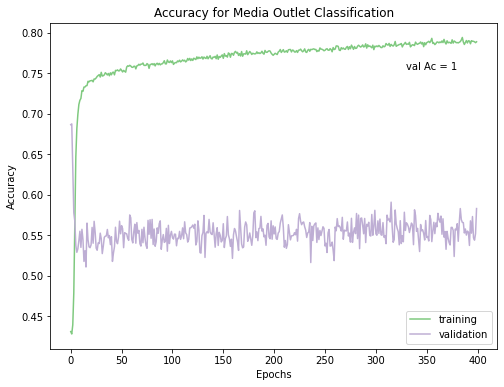

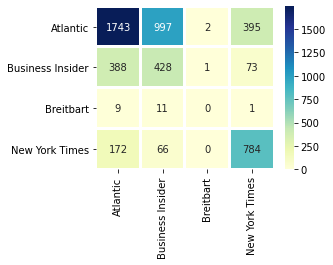

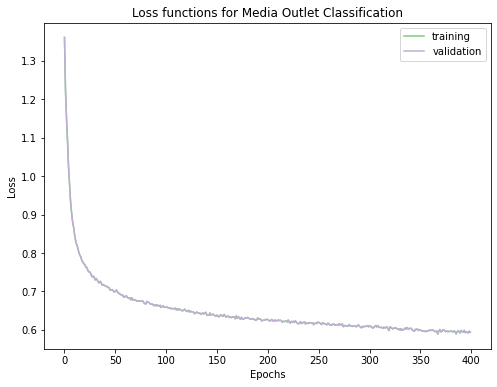

In [ ]:
# Plot accuracy curves:
with sns.color_palette("Accent", n_colors=8):
    plt.figure(figsize=(8,6))
    sns.lineplot(data=np.asarray(m_h.history['acc']))
    sns.lineplot(data=np.asarray(m_h.history['val_acc']))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy for Media Outlet Classification") # change title here
    plt.legend(labels=['training', 'validation'],loc='lower right')
    plt.text(330,0.755,'val Ac = ' + str(round(f1_score(y_test,news_ANN.predict_classes(x_test),average='weighted')))) 
    plt.savefig('outlets_bias_acc.svg',format='svg') # edit file title here

# Plot confusion matrix:
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test,news_ANN.predict_classes(x_test)),annot=True,linewidths=2, cmap="YlGnBu",fmt="g", xticklabels=['Atlantic','Business Insider','Breitbart','New York Times'], yticklabels=['Atlantic','Business Insider','Breitbart','New York Times'])
plt.autoscale()
plt.savefig('confusion_matrix_outlet_bias_bal.png',format='PNG',bbox_inches = "tight") # edit file title here

# Plot loss curves:
with sns.color_palette("Accent", n_colors=8):
    plt.figure(figsize=(8,6))
    sns.lineplot(data=np.asarray(m_h.history['loss']))
    sns.lineplot(data=np.asarray(m_h.history['loss']))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss functions for Media Outlet Classification") 
    plt.legend(labels=['training', 'validation'])
    plt.savefig('outlets_bias_loss.svg',format='SVG') 


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn import svm
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

In [ ]:
#Implementing MAchine Learning Models
#Implement Decision Tree:
#Plot the decision tree
decision_tree = DecisionTreeClassifier(max_depth=5)
decision_tree.fit(x_train, y_train)
Y_prediction = decision_tree.predict(x_train)
accuracy_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
print(accuracy_decision_tree)

66.25


In [ ]:
#Implementing Logistic Regression
#Logistic Regression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
Y_pred = logreg.predict(x_test)
acc_log = round(logreg.score(x_train, y_train) * 100, 2)
print(acc_log)

73.23


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# Support Vector Machines
svc = SVC()
svc.fit(x_train, y_train)
Y_predSVM = svc.predict(x_test)
acc_svc = round(svc.score(x_train, y_train) * 100, 2)
acc_svc

77.03

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)
Y_predKNN = knn.predict(x_test)
acc_knn = round(knn.score(x_train, y_train) * 100, 2)
print(acc_knn)

78.45


In [ ]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
Y_pred = gaussian.predict(x_test)
acc_gaussian = round(gaussian.score(x_train, y_train) * 100, 2)
print(acc_gaussian)

34.39


In [ ]:
# Linear SVC

linear_svc = LinearSVC(max_iter=10000)
linear_svc.fit(x_train, y_train)
Y_pred = linear_svc.predict(x_test)
acc_linear_svc = round(linear_svc.score(x_train, y_train) * 100, 2)
print(acc_linear_svc)

73.88


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(x_train, y_train)
Y_pred = sgd.predict(x_test)
acc_sgd = round(sgd.score(x_train, y_train) * 100, 2)
print(acc_sgd)

68.22


In [ ]:
models = pd.DataFrame({
    'Model' : ['Support Vector Machines', 'KNN', 'Logistic Regression',
               'Gaussian', 'Stochastic Gradient Decent', 'Linear SVC',
               'Decision Tree'],
    'Score' : [acc_svc,acc_knn,acc_log,acc_gaussian,acc_sgd,acc_linear_svc,accuracy_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
1,KNN,78.45
0,Support Vector Machines,77.03
5,Linear SVC,73.88
2,Logistic Regression,73.23
4,Stochastic Gradient Decent,68.22
6,Decision Tree,66.25
3,Gaussian,34.39


Media Bias Classifier

In [ ]:
#Media Bias classifier

In [ ]:
# split into shuffled folds:
#Note that you should edit the class array accordingly: Bias (classes_Bias) or Outlet (classes_All)
#Scaler = MinMaxScaler()
import sklearn
split_shuffle = StratifiedShuffleSplit(n_splits=1, test_size=0.33) # choose one split to make analysis faster. change it if required
for train, test in split_shuffle.split(feature_array,classes_bias_classifier):
  # Scale the data with StandardScaler before splitting:
    x_train, x_test = sklearn.preprocessing.StandardScaler().fit_transform(feature_array)[train], \
    sklearn.preprocessing.StandardScaler().fit_transform(feature_array)[test]

    y_train, y_test = classes_bias_classifier[train]-1,classes_bias_classifier[test]-1


In [ ]:
#fit the network. You can change parameters to see how this affects your training.
m_h = news_ANN.fit(x_train, y_train, epochs=400, \
validation_data=(x_test, y_test), batch_size=32, verbose=0)

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test,news_ANN.predict_classes(x_test),average='weighted')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.8725685279585262

In [ ]:
#Resampling:
[x_train_resample, y_train_resample] = SMOTE().fit_resample(x_train, y_train)

#model fitting:
m_h = news_ANN.fit(x_train_resample, y_train_resample, epochs=400, \
validation_data=(x_test, y_test), batch_size=32, verbose=0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


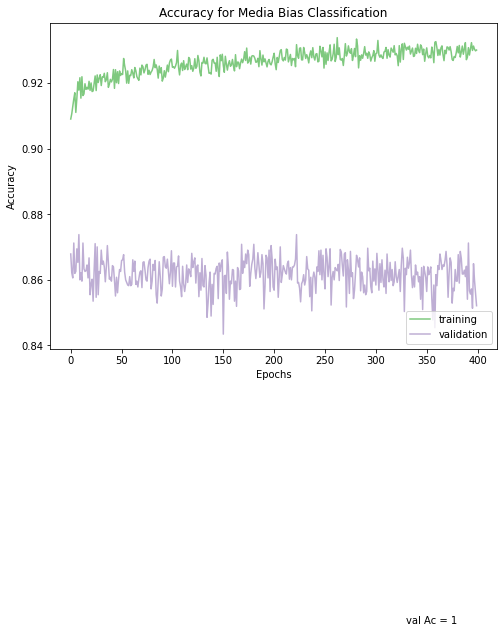

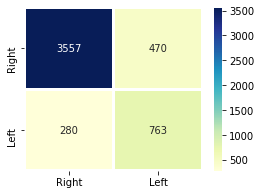

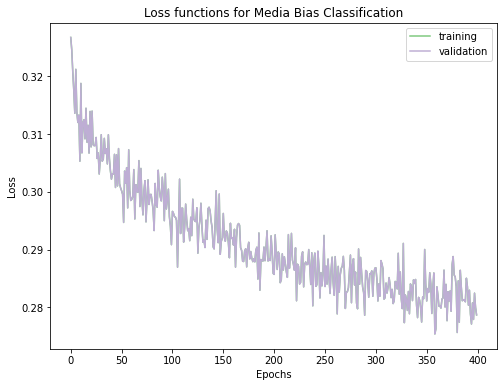

In [ ]:
# Plot accuracy curves:
with sns.color_palette("Accent", n_colors=8):
    plt.figure(figsize=(8,6))
    sns.lineplot(data=np.asarray(m_h.history['acc']))
    sns.lineplot(data=np.asarray(m_h.history['val_acc']))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy for Media Bias Classification") # change title here
    plt.legend(labels=['training', 'validation'],loc='lower right')
    plt.text(330,0.755,'val Ac = ' + str(round(f1_score(y_test,news_ANN.predict_classes(x_test),average='weighted')))) 
    plt.savefig('outlets_bias_acc.svg',format='svg') # edit file title here

# Plot confusion matrix:
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test,news_ANN.predict_classes(x_test)),annot=True,linewidths=2, cmap="YlGnBu",fmt="g", xticklabels=['Right','Left'],yticklabels=['Right','Left']) 
plt.autoscale()
plt.savefig('confusion_matrix_outlet_bias_bal.png',format='PNG',bbox_inches = "tight") # edit file title here


# Plot loss curves:
with sns.color_palette("Accent", n_colors=8):
    plt.figure(figsize=(8,6))
    sns.lineplot(data=np.asarray(m_h.history['loss']))
    sns.lineplot(data=np.asarray(m_h.history['loss']))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss functions for Media Bias Classification") #change title here
    plt.legend(labels=['training', 'validation'])
    plt.savefig('outlets_bias_loss.svg',format='SVG') # edit file title here


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
#Implementing MAchine Learning Models
#Implement Decision Tree:
#Plot the decision tree
decision_tree = DecisionTreeClassifier(max_depth=5)
decision_tree.fit(x_train, y_train)
Y_prediction = decision_tree.predict(x_train)
accuracy_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
print(accuracy_decision_tree)

83.18


In [ ]:
#Implementing Logistic Regression
#Logistic Regression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
Y_pred = logreg.predict(x_test)
acc_log = round(logreg.score(x_train, y_train) * 100, 2)
acc_log

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


89.96

In [ ]:
# Support Vector Machines
svc = SVC()
svc.fit(x_train, y_train)
Y_predSVM = svc.predict(x_test)
acc_svc = round(svc.score(x_train, y_train) * 100, 2)
acc_svc

93.33

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)
Y_predKNN = knn.predict(x_test)
acc_knn = round(knn.score(x_train, y_train) * 100, 2)
acc_knn

90.69

In [ ]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
Y_pred = gaussian.predict(x_test)
acc_gaussian = round(gaussian.score(x_train, y_train) * 100, 2)
acc_gaussian

68.29

In [ ]:
# Linear SVC

linear_svc = LinearSVC(max_iter=10000)
linear_svc.fit(x_train, y_train)
Y_pred = linear_svc.predict(x_test)
acc_linear_svc = round(linear_svc.score(x_train, y_train) * 100, 2)
acc_linear_svc

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


90.49

In [ ]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(x_train, y_train)
Y_pred = sgd.predict(x_test)
acc_sgd = round(sgd.score(x_train, y_train) * 100, 2)
acc_sgd

86.82

In [ ]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Naive Bayes',  
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
               acc_gaussian, 
              acc_sgd, acc_linear_svc, accuracy_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,Support Vector Machines,93.33
1,KNN,90.69
5,Linear SVC,90.49
2,Logistic Regression,89.96
4,Stochastic Gradient Decent,86.82
6,Decision Tree,83.18
3,Naive Bayes,68.29
